# GR5398 26 Spring: FinRL-Trading Quantitative Trading Strategy Track
## Assignment 1

In this assignment 1, we want you to :
+ Run this ipynb file, which is a simplified FinRL-Trading whole process, and have a basic knowledge of what we will do in this semester
+ Design a portfolio using the selected stocks, and learn some fundamental information of quantitative trading (especially stock selection part)
+ Implement a full backtest process to verify your strategy's performance using real historical data
+ Summarize your result in a very brief research report, and write a `Medium Blog`. Submit your code files onto GitHub repo in a new folder called Assignment1_Name_UNI.
    + An example of medium blog: [Applying new LLMs on FinGPT: Fine-tune DeepSeek and Llama3](https://medium.com/p/6ac9198d88b2)

Assignment 1 Report Submission Due Day: **Feb 20, 2026**.

For full `FinRL-Trading` project, please refer to [AI4Finance/FinRL-Trading](https://github.com/AI4Finance-Foundation/FinRL-Trading/tree/master_backup).

### 0. Prerequisities

First, you should decide your stock pool for later selection. Here we recommend you to choose your portfolio from S&P 500 index or NASDAQ 100 index. We have already provided you with their components.

Then, you should download stock's daily OHLCV data on [WRDS-Security Daily](https://wrds-www.wharton.upenn.edu/pages/get-data/compustat-capital-iq-standard-poors/compustat/north-america-daily/security-daily/) and quarterly fundamental data on [WRDS-Fundamental Quarterly](https://wrds-www.wharton.upenn.edu/pages/get-data/compustat-capital-iq-standard-poors/compustat/north-america-daily/security-daily/) for later usage.

+ Note: Here we highly recommend you to register for a WRDS account which our university has provided for all master students for free. Please follow the instruction below to get a WRDS account:
    + https://guides.library.columbia.edu/wrds

If you don't have enough storage or want this data file to be loaded faster while doing calculation, you can select these columns below only while querying the WRDS database.
+ prccd (Price - Close - Daily)
+ prcod (Price - Open - Daily)
+ ajexdi (Adjustment Factor (Issue)-Cumulative by Ex-Date)
+ tic (Ticker)

Since we want you to implement backtest from **Jan 1, 2018** to **Dec 31, 2025**, we suggest you to download all the data during this period.

### 1. Data Preprocessing

In this part, we will preprocess all the fundamental data for our Machine Learning algorithms. Please refer to [AI4Finance/FinRL-Trading/data_processor/Step2_preprocess_fundmental_data.py](https://github.com/AI4Finance-Foundation/FinRL-Trading/blob/master_backup/data_processor/Step2_preprocess_fundmental_data.py) for detailed usage.

After running this part, you should get a folder with final fundamental ratios split into different industry sections in `xlsx` files.

In [3]:
import os
import pandas as pd
import numpy as np
import warnings
from datetime import datetime as dt
import sys
import time
from pathlib import Path
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

warnings.filterwarnings("ignore")

In [5]:
def load_data(fundamental_file, price_file):
    """
    Load fundamental and price data from CSV files.
    
    Args:
        fundamental_file (str): Path to fundamental data CSV file
        price_file (str): Path to price data CSV file
        
    Returns:
        tuple: (fundamental_df, price_df)
    """
    print("Loading data files...")
    
    if not os.path.isfile(fundamental_file):
        raise FileNotFoundError(f"Fundamental file {fundamental_file} not found.")
    
    if not os.path.isfile(price_file):
        raise FileNotFoundError(f"Price file {price_file} not found.")
    
    # Load fundamental data
    fund_df = pd.read_csv(fundamental_file)
    print(fund_df.head())
    
    # For price data, only load necessary columns to save memory
    print("Loading price data (only necessary columns)...")
    price_columns = ['gvkey', 'tic', 'datadate', 'prccd', 'ajexdi']
    df_daily_price = pd.read_csv(price_file, usecols=price_columns)
    print(df_daily_price.head())
    
    print(f"Fundamental data shape: {fund_df.shape}")
    print(f"Price data shape: {df_daily_price.shape}")
    print(f"Unique tickers in fundamental data: {len(fund_df.tic.unique())}")
    print(f"Unique tickers in price data: {len(df_daily_price.tic.unique())}")
    
    return fund_df, df_daily_price

In [7]:
def adjust_trade_dates(fund_df):
    """
    Adjust trade dates to use trading dates instead of quarterly report dates.
    
    Args:
        fund_df (pandas.DataFrame): Fundamental data DataFrame
        
    Returns:
        pandas.DataFrame: DataFrame with adjusted trade dates
    """
    print("Adjusting trade dates...")
    
    # Convert datadate to datetime first, then to integer format
    datadate_dt = pd.to_datetime(fund_df['datadate'])

    fund_df['tradedate'] = ((datadate_dt.dt.to_period('Q')).dt.end_time.dt.normalize())
    fund_df['reportdate'] = fund_df["rdq"]
    
    return fund_df

In [9]:
def calculate_adjusted_close(fund_df):
    """
    Calculate adjusted close price.
    
    Args:
        fund_df (pandas.DataFrame): Fundamental data DataFrame
        
    Returns:
        pandas.DataFrame: DataFrame with adjusted close price
    """
    print("Calculating adjusted close price...")
    fund_df['adj_close_q'] = fund_df.prccq / fund_df.adjex
    return fund_df

In [11]:
def match_tickers_and_gvkey(fund_df, df_daily_price):
    """
    Match tickers and gvkey for fundamental and price data.
    
    Args:
        fund_df (pandas.DataFrame): Fundamental data DataFrame
        df_daily_price (pandas.DataFrame): Price data DataFrame
        
    Returns:
        pandas.DataFrame: Filtered fundamental data DataFrame
    """
    print("Matching tickers and gvkey...")
    
    # Create mapping from ticker to gvkey
    tic_to_gvkey = {}
    df_daily_groups = list(df_daily_price.groupby('tic'))
    
    for tic, df_ in df_daily_groups:
        tic_to_gvkey[tic] = df_.gvkey.iloc[0]
    
    print(f"Original fundamental data shape: {fund_df.shape}")
    
    # Filter fundamental data to only include tickers present in price data
    fund_df = fund_df[np.isin(fund_df.tic, list(tic_to_gvkey.keys()))]
    
    print(f"Filtered fundamental data shape: {fund_df.shape}")
    print(f"Unique gvkeys: {len(fund_df.gvkey.unique())}")
    
    # Add gvkey mapping
    fund_df['gvkey'] = [tic_to_gvkey[x] for x in fund_df['tic']]
    
    return fund_df

In [13]:
def calculate_next_quarter_returns(fund_df):
    """
    Calculate next quarter's return for each stock.
    
    Args:
        fund_df (pandas.DataFrame): Fundamental data DataFrame
        
    Returns:
        pandas.DataFrame: DataFrame with next quarter returns
    """
    print("Calculating next quarter returns...")
    
    fund_df['date'] = fund_df["tradedate"]
    # fund_df['date'] = pd.to_datetime(fund_df['date'], format="%Y-%m%d")
    fund_df['date'] = pd.to_datetime(fund_df['date'])
    fund_df.drop_duplicates(["date", "gvkey"], keep='last', inplace=True)
    
    # Calculate next quarter return for each stock
    l_df = list(fund_df.groupby('gvkey'))
    for tic, df in l_df:
        df.reset_index(inplace=True, drop=True)
        df.sort_values('date')
        # Calculate next quarter's return
        df['y_return'] = np.log(df['adj_close_q'].shift(-1) / df['adj_close_q'])
    
    fund_df = pd.concat([x[1] for x in l_df])
    
    print(f"Data shape after calculating returns: {fund_df.shape}")
    return fund_df

In [15]:
def calculate_basic_ratios(fund_df):
    """
    Calculate basic financial ratios (PE, PS, PB).
    
    Args:
        fund_df (pandas.DataFrame): Fundamental data DataFrame
        
    Returns:
        pandas.DataFrame: DataFrame with basic ratios
    """
    print("Calculating basic financial ratios...")
    
    fund_df['pe'] = fund_df.prccq / fund_df.epspxq
    fund_df['ps'] = fund_df.prccq / (fund_df.revtq / fund_df.cshoq)
    fund_df['pb'] = fund_df.prccq / ((fund_df.atq - fund_df.ltq) / fund_df.cshoq)
    
    return fund_df

In [17]:
def select_columns(fund_df):
    """
    Select relevant columns for analysis.
    
    Args:
        fund_df (pandas.DataFrame): Fundamental data DataFrame
        
    Returns:
        pandas.DataFrame: DataFrame with selected columns
    """
    print("Selecting relevant columns...")
    
    items = [
        'date', 'gvkey', 'tic', 'gsector',
        'oiadpq', 'revtq', 'niq', 'atq', 'teqq', 'epspiy', 'ceqq', 'cshoq', 'dvpspq',
        'actq', 'lctq', 'cheq', 'rectq', 'cogsq', 'invtq', 'apq', 'dlttq', 'dlcq', 'ltq',
        'pe', 'ps', 'pb', 'adj_close_q', 'y_return', 'reportdate'
    ]
    
    fund_data = fund_df[items]
    
    # Rename columns for readability
    fund_data = fund_data.rename(columns={
        'oiadpq': 'op_inc_q',
        'revtq': 'rev_q',
        'niq': 'net_inc_q',
        'atq': 'tot_assets',
        'teqq': 'sh_equity',
        'epspiy': 'eps_incl_ex',
        'ceqq': 'com_eq',
        'cshoq': 'sh_outstanding',
        'dvpspq': 'div_per_sh',
        'actq': 'cur_assets',
        'lctq': 'cur_liabilities',
        'cheq': 'cash_eq',
        'rectq': 'receivables',
        'cogsq': 'cogs_q',
        'invtq': 'inventories',
        'apq': 'payables',
        'dlttq': 'long_debt',
        'dlcq': 'short_debt',
        'ltq': 'tot_liabilities'
    })
    
    return fund_data

In [19]:
def calculate_financial_ratios(fund_data):
    """
    Calculate comprehensive financial ratios.
    
    Args:
        fund_data (pandas.DataFrame): Fundamental data DataFrame
        
    Returns:
        pandas.DataFrame: DataFrame with all financial ratios
    """
    print("Calculating comprehensive financial ratios...")
    
    # Set data type to series
    date = fund_data['date'].to_frame('date').reset_index(drop=True)
    reportdate = fund_data['reportdate'].to_frame('reportdate').reset_index(drop=True)
    tic = fund_data['tic'].to_frame('tic').reset_index(drop=True)
    gvkey = fund_data['gvkey'].to_frame('gvkey').reset_index(drop=True)
    adj_close_q = fund_data['adj_close_q'].to_frame('adj_close_q').reset_index(drop=True)
    y_return = fund_data['y_return'].to_frame('y_return').reset_index(drop=True)
    gsector = fund_data['gsector'].to_frame('gsector').reset_index(drop=True)
    pe = fund_data['pe'].to_frame('pe').reset_index(drop=True)
    ps = fund_data['ps'].to_frame('ps').reset_index(drop=True)
    pb = fund_data['pb'].to_frame('pb').reset_index(drop=True)
    
    # Profitability ratios
    print("  Calculating profitability ratios...")
    
    # Operating Margin
    OPM = pd.Series(np.empty(fund_data.shape[0], dtype=object), name='OPM')
    for i in range(0, fund_data.shape[0]):
        if i-3 < 0:
            OPM[i] = np.nan
        elif fund_data.iloc[i, 1] != fund_data.iloc[i-3, 1]:
            OPM.iloc[i] = np.nan
        else:
            OPM.iloc[i] = np.sum(fund_data['op_inc_q'].iloc[i-3:i]) / np.sum(fund_data['rev_q'].iloc[i-3:i])
    OPM = pd.Series(OPM).to_frame().reset_index(drop=True)
    
    # Net Profit Margin
    NPM = pd.Series(np.empty(fund_data.shape[0], dtype=object), name='NPM')
    for i in range(0, fund_data.shape[0]):
        if i-3 < 0:
            NPM[i] = np.nan
        elif fund_data.iloc[i, 1] != fund_data.iloc[i-3, 1]:
            NPM.iloc[i] = np.nan
        else:
            NPM.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i]) / np.sum(fund_data['rev_q'].iloc[i-3:i])
    NPM = pd.Series(NPM).to_frame().reset_index(drop=True)
    
    # Return On Assets
    ROA = pd.Series(np.empty(fund_data.shape[0], dtype=object), name='ROA')
    for i in range(0, fund_data.shape[0]):
        if i-3 < 0:
            ROA[i] = np.nan
        elif fund_data.iloc[i, 1] != fund_data.iloc[i-3, 1]:
            ROA.iloc[i] = np.nan
        else:
            ROA.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i]) / fund_data['tot_assets'].iloc[i]
    ROA = pd.Series(ROA).to_frame().reset_index(drop=True)
    
    # Return on Equity
    ROE = pd.Series(np.empty(fund_data.shape[0], dtype=object), name='ROE')
    for i in range(0, fund_data.shape[0]):
        if i-3 < 0:
            ROE[i] = np.nan
        elif fund_data.iloc[i, 1] != fund_data.iloc[i-3, 1]:
            ROE.iloc[i] = np.nan
        else:
            ROE.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i]) / fund_data['sh_equity'].iloc[i]
    ROE = pd.Series(ROE).to_frame().reset_index(drop=True)
    
    # Per share items
    EPS = fund_data['eps_incl_ex'].to_frame('EPS').reset_index(drop=True)
    BPS = (fund_data['com_eq'] / fund_data['sh_outstanding']).to_frame('BPS').reset_index(drop=True)
    DPS = fund_data['div_per_sh'].to_frame('DPS').reset_index(drop=True)
    
    # Liquidity ratios
    print("  Calculating liquidity ratios...")
    cur_ratio = (fund_data['cur_assets'] / fund_data['cur_liabilities']).to_frame('cur_ratio').reset_index(drop=True)
    quick_ratio = ((fund_data['cash_eq'] + fund_data['receivables']) / fund_data['cur_liabilities']).to_frame('quick_ratio').reset_index(drop=True)
    cash_ratio = (fund_data['cash_eq'] / fund_data['cur_liabilities']).to_frame('cash_ratio').reset_index(drop=True)
    
    # Efficiency ratios
    print("  Calculating efficiency ratios...")
    
    # Inventory turnover ratio
    inv_turnover = pd.Series(np.empty(fund_data.shape[0], dtype=object), name='inv_turnover')
    for i in range(0, fund_data.shape[0]):
        if i-3 < 0:
            inv_turnover[i] = np.nan
        elif fund_data.iloc[i, 1] != fund_data.iloc[i-3, 1]:
            inv_turnover.iloc[i] = np.nan
        else:
            inv_turnover.iloc[i] = np.sum(fund_data['cogs_q'].iloc[i-3:i]) / fund_data['inventories'].iloc[i]
    inv_turnover = pd.Series(inv_turnover).to_frame().reset_index(drop=True)
    
    # Receivables turnover ratio
    acc_rec_turnover = pd.Series(np.empty(fund_data.shape[0], dtype=object), name='acc_rec_turnover')
    for i in range(0, fund_data.shape[0]):
        if i-3 < 0:
            acc_rec_turnover[i] = np.nan
        elif fund_data.iloc[i, 1] != fund_data.iloc[i-3, 1]:
            acc_rec_turnover.iloc[i] = np.nan
        else:
            acc_rec_turnover.iloc[i] = np.sum(fund_data['rev_q'].iloc[i-3:i]) / fund_data['receivables'].iloc[i]
    acc_rec_turnover = pd.Series(acc_rec_turnover).to_frame().reset_index(drop=True)
    
    # Payable turnover ratio
    acc_pay_turnover = pd.Series(np.empty(fund_data.shape[0], dtype=object), name='acc_pay_turnover')
    for i in range(0, fund_data.shape[0]):
        if i-3 < 0:
            acc_pay_turnover[i] = np.nan
        elif fund_data.iloc[i, 1] != fund_data.iloc[i-3, 1]:
            acc_pay_turnover.iloc[i] = np.nan
        else:
            acc_pay_turnover.iloc[i] = np.sum(fund_data['cogs_q'].iloc[i-3:i]) / fund_data['payables'].iloc[i]
    acc_pay_turnover = pd.Series(acc_pay_turnover).to_frame().reset_index(drop=True)
    
    # Leverage ratios
    print("  Calculating leverage ratios...")
    debt_ratio = (fund_data['tot_liabilities'] / fund_data['tot_assets']).to_frame('debt_ratio').reset_index(drop=True)
    debt_to_equity = (fund_data['tot_liabilities'] / fund_data['sh_equity']).to_frame('debt_to_equity').reset_index(drop=True)
    
    # Create final ratios dataframe
    ratios = pd.concat([
        date, gvkey, tic, gsector, adj_close_q, y_return,
        OPM, NPM, ROA, ROE, EPS, BPS, DPS,
        cur_ratio, quick_ratio, cash_ratio, inv_turnover, acc_rec_turnover, acc_pay_turnover,
        debt_ratio, debt_to_equity, pe, ps, pb, reportdate
    ], axis=1).reset_index(drop=True)
    
    return ratios

In [21]:
def handle_missing_values(ratios):
    """
    Handle missing values and infinite values in the dataset.
    
    Args:
        ratios (pandas.DataFrame): DataFrame with financial ratios
        
    Returns:
        pandas.DataFrame: Cleaned DataFrame
    """
    print("Handling missing values...")
    
    # Replace NAs and infinite values with zero initially
    final_ratios = ratios.copy()
    final_ratios = final_ratios.fillna(0)
    final_ratios = final_ratios.replace(np.inf, 0)
    
    # Define financial features columns
    features_column_financial = [
        'OPM', 'NPM', 'ROA', 'ROE', 'EPS', 'BPS', 'DPS', 'cur_ratio',
        'quick_ratio', 'cash_ratio', 'inv_turnover', 'acc_rec_turnover',
        'acc_pay_turnover', 'debt_ratio', 'debt_to_equity', 'pe', 'ps', 'pb'
    ]
    
    # Remove rows with zero adjusted close price
    final_ratios = final_ratios.drop(list(final_ratios[final_ratios.adj_close_q == 0].index)).reset_index(drop=True)
    
    # Convert to numeric and handle invalid values
    final_ratios['y_return'] = pd.to_numeric(final_ratios['y_return'], errors='coerce')
    for col in features_column_financial:
        if col in final_ratios.columns:
            final_ratios[col] = pd.to_numeric(final_ratios[col], errors='coerce')
    
    final_ratios['y_return'].replace([np.nan, np.inf, -np.inf], np.nan, inplace=True)
    final_ratios[features_column_financial].replace([np.nan, np.inf, -np.inf], np.nan, inplace=True)
    
    # Remove columns with too many invalid values
    dropped_col = []
    for col in features_column_financial:
        if col in final_ratios.columns and np.any(~np.isfinite(final_ratios[col])):
            final_ratios.drop(columns=[col], axis=1, inplace=True)
            dropped_col.append(col)
    
    # Remove rows with any missing values
    final_ratios.dropna(axis=0, inplace=True)
    final_ratios = final_ratios[final_ratios["reportdate"].ne(0)]  
    final_ratios = final_ratios.reset_index(drop=True)
    
    print(f"Dropped columns: {dropped_col}")
    print(f"Final data shape: {final_ratios.shape}")
    
    return final_ratios

In [23]:
def save_results(final_ratios, output_dir="outputs", include_sector0=False):
    """
    Save the processed data to files.
    
    Args:
        final_ratios (pandas.DataFrame): Final processed data
        output_dir (str): Output directory
        include_sector0 (bool): Whether to include sector 0 in sector-specific files (default: False)
    """
    print("Saving results...")
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Format date column
    # final_ratios.date = final_ratios.date.apply(lambda x: x.strftime('%Y-%m-%d'))
    
    # Save main results
    main_output_file = os.path.join(output_dir, 'final_ratios.csv')
    final_ratios.to_csv(main_output_file, index=False)
    print(f"Main results saved to: {main_output_file}")
    
    # Save by sector
    print("Saving sector-specific files...")
    sector_count = 0
    for sec, df_ in list(final_ratios.groupby('gsector')):
        # Skip sector 0 unless explicitly included
        if sec == 0 and not include_sector0:
            print(f"  Skipping Sector 0: {len(df_)} records (stocks with missing sector information)")
            continue
        
        sector_file = os.path.join(output_dir, f"sector{int(sec)}.xlsx")
        df_.to_excel(sector_file, index=False)
        print(f"  Sector {int(sec)}: {sector_file} ({len(df_)} records)")
        sector_count += 1
    
    print(f"  Total sectors saved: {sector_count}")
    
    return main_output_file

In [25]:
Stock_Index_fundation_file = "nasdaq_fundamental.csv"
Stock_Index_price_file = "nasdaq_stocks.csv"
output_dir = "outputs"
include_sector0 = False

In [27]:
print("=" * 80)
print("S&P 500 Fundamental Data Preprocessing Tool")
print("=" * 80)
print(f"Fundamental file: {Stock_Index_fundation_file}")
print(f"Price file: {Stock_Index_price_file}")
print(f"Output directory: {output_dir}")
print(f"Include sector 0 in sector files: {include_sector0}")
print("-" * 80)

# Load data
fund_df, df_daily_price = load_data(Stock_Index_fundation_file, Stock_Index_price_file)

# Process data
fund_df = adjust_trade_dates(fund_df)
fund_df = calculate_adjusted_close(fund_df)
fund_df = match_tickers_and_gvkey(fund_df, df_daily_price)
fund_df = calculate_next_quarter_returns(fund_df)
fund_df = calculate_basic_ratios(fund_df)

# Select and process columns
fund_data = select_columns(fund_df)

# Calculate financial ratios
ratios = calculate_financial_ratios(fund_data)

# Handle missing values
final_ratios = handle_missing_values(ratios)

# Save results
output_file = save_results(final_ratios, output_dir, include_sector0)

print("\n" + "=" * 80)
print("Processing completed successfully!")
print(f"Final dataset shape: {final_ratios.shape}")
print(f"Output saved to: {output_file}")
print("=" * 80)

S&P 500 Fundamental Data Preprocessing Tool
Fundamental file: nasdaq_fundamental.csv
Price file: nasdaq_stocks.csv
Output directory: outputs
Include sector 0 in sector files: False
--------------------------------------------------------------------------------
Loading data files...
  costat curcdq datafmt indfmt consol   tic    datadate  gvkey       conm  \
0      A    USD     STD   INDL      C  AAPL  2018-03-31   1690  APPLE INC   
1      A    USD     STD   INDL      C  AAPL  2018-06-30   1690  APPLE INC   
2      A    USD     STD   INDL      C  AAPL  2018-09-30   1690  APPLE INC   
3      A    USD     STD   INDL      C  AAPL  2018-12-31   1690  APPLE INC   
4      A    USD     STD   INDL      C  AAPL  2019-03-31   1690  APPLE INC   

       cusip  ...     xrdy    xsgay  adjex        cshtrq dvpspq  dvpsxq  \
0  037833100  ...   6785.0  15166.0    4.0  2.285739e+09   0.63    0.63   
1  037833100  ...  10486.0  22975.0    4.0  1.807002e+09   0.73    0.73   
2  037833100  ...  14236.0  

### 2. Stock Selection

In this part, we will use processed fundamental data to predict stocks' future return.

To be specific, we will use 3 different machine learning algorithms (Random Forest, LightGBM, XGBoost) to predict next quarter's performance. Instead of setting a specific date to calculate all the future returns, here we optimized to predict dynamically. While there is a new report published, we can immediately renew its latest prediction. Then, we choose stocks with top k% (you can adjust this rate by yourself) predicted return as our portfolio.

For details, please refer to `fundamental_run_model.py` and `ml_model.py`. Also, we recommend you to try DRL stock selection and reallocation algorithm in [AI4Finance/FinRL-Trading/fundamental_portfolio_drl.py](https://github.com/AI4Finance-Foundation/FinRL-Trading/blob/master_backup/fundamental_portfolio_drl.py).

After running this part, you should get a csv file contains all your portfolio's components history.

In [29]:
def create_directory_if_not_exists(directory_path):
    """
    Create directory if it doesn't exist
    
    Args:
        directory_path (str): Directory path
    """
    path = Path(directory_path)
    if not path.exists():
        path.mkdir(parents=True, exist_ok=True)
        print(f"✓ Created directory: {directory_path}")
    else:
        print(f"✓ Directory already exists: {directory_path}")

def quarter_ffill(df: pd.DataFrame) -> pd.DataFrame:
    qkey = df.index.to_period("Q")
    df = df.groupby(qkey).ffill()
    return df

def quarter_reportday_ffill(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    full_idx = pd.bdate_range(df.index.min(), df.index.max())

    out = df.reindex(full_idx)
    out = out.sort_index().copy()
    idx = out.index
    for col in out.columns:
        s = out[col]
        if not s.notna().any():
            continue
        dates = s.dropna().index
        for i, t0 in enumerate(dates):
            val = s.at[t0]
            t1 = dates[i + 1] if i + 1 < len(dates) else None
            cap = (t0.to_period('Q') + 1).end_time.normalize()
            mask = (idx > t0) & (idx < (t1 if t1 and t1 <= cap else cap + pd.Timedelta('1ns')))
            out.loc[mask, col] = val
    return out

In [30]:
def run_stock_selection(data_path, output_path):
    """
    Run stock selection model
    
    Args:
        data_path (str): Input sector files directory
        output_path (str): Output directory
    """
    # Define sector range
    sectors = range(10, 65, 5)
    
    # Set data directory path
    DATA_DIR = data_path
    FUNDAMENTAL_FILE = os.path.join(DATA_DIR, "final_ratios.csv")
    
    print(f"Using data directory: {DATA_DIR}")
    print(f"Fundamental data file: {FUNDAMENTAL_FILE}")
    print(f"Output directory: {output_path}")
    print(f"Sector range: {list(sectors)}")
    
    # Check if input file exists
    if not os.path.exists(FUNDAMENTAL_FILE):
        print(f"Error: Fundamental data file does not exist: {FUNDAMENTAL_FILE}")
        sys.exit(1)
    
    # Create output directory
    create_directory_if_not_exists(output_path)
    
    # gvkey is unique identifier
    df_dict = {'tic': [], 'predicted_return': [], 'trade_date': []}
    
    # ===== Run stock selection for all sectors in my_outputs directory =====
    start = time.time()
    print("\nStarting stock selection model for all sectors...")

    df_all = pd.DataFrame()
    
    for sector in sectors:
        sector_file = os.path.join(DATA_DIR, f"sector{sector}.xlsx")
        print(f"\nProcessing sector{sector}...")
        
        # Check if sector file exists
        if not os.path.exists(sector_file):
            print(f"   Warning: Sector file does not exist, skipping: {sector_file}")
            continue
        
        # Run model training - using files from specified directory
        cmd = f"{sys.executable} fundamental_run_model.py -sector_name sector{sector} -tic_column tic -fundamental {FUNDAMENTAL_FILE} -sector {sector_file}"
        print(f"Executing command: {cmd}")
        
        result = os.system(cmd)
        if result != 0:
            print(f" sector{sector} model training failed")
            continue
        
        # Read prediction results
        result_file = f"results/sector{sector}/df_predict_best.csv"
        if not os.path.exists(result_file):
            print(f" Prediction result file does not exist: {result_file}")
            continue

        df = pd.read_csv(result_file, index_col=0)
        df.index = pd.to_datetime(df.index)
        print(f"  Reading prediction results: {df.shape[0]} dates, {df.shape[1]} stocks")
        df = quarter_reportday_ffill(df)
        df_all = pd.concat([df_all, df], axis=1)
        print(f" sector{sector} processing completed")

    for idx in df_all.index:
        predicted_return = df_all.loc[idx]
        ### Choose top 25% stocks, or you can adjust by yourself
        btm_q = predicted_return.quantile(0.75)
        # top_q = predicted_return.quantile(1)
        predicted_return = predicted_return[predicted_return >= btm_q]
        # predicted_return = predicted_return[(predicted_return >= btm_q) & (predicted_return <= top_q)]
        for tic in predicted_return.index:
            df_dict["tic"].append(tic)
            df_dict["predicted_return"].append(predicted_return[tic])
            df_dict["trade_date"].append(idx)
    
    end = time.time()
    
    print(f"\nTotal time: {(end-start)/60:.2f} minutes")
    print(f"Processing completed! Total records: {len(df_dict['tic'])}")
    
    # Create result DataFrame
    df_result = pd.DataFrame(df_dict)
    
    # Save results to CSV file
    output_file = os.path.join(output_path, "stock_selected.csv")
    df_result.to_csv(output_file, index=False)
    print(f"Results saved to: {output_file}")
    
    # Display result statistics
    if len(df_result) > 0:
        print(f"\nResult statistics:")
        print(f"  Total records: {len(df_result)}")
        print(f"  Unique stocks: {df_result['tic'].nunique()}")
        print(f"  Date range: {df_result['trade_date'].min()} to {df_result['trade_date'].max()}")
        print(f"  Predicted return range: {df_result['predicted_return'].min():.4f} to {df_result['predicted_return'].max():.4f}")
    else:
        print("\nWarning: No stock selection results generated")

In [31]:
data_path = "outputs"
output_path_step2 = "outputs_step2"

In [32]:
run_stock_selection(data_path, output_path_step2)

Using data directory: outputs
Fundamental data file: outputs/final_ratios.csv
Output directory: outputs_step2
Sector range: [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
✓ Directory already exists: outputs_step2

Starting stock selection model for all sectors...

Processing sector10...

Processing sector15...
Executing command: /opt/anaconda3/bin/python fundamental_run_model.py -sector_name sector15 -tic_column tic -fundamental outputs/final_ratios.csv -sector outputs/sector15.xlsx
xgb:1.742670s
gbm:0.932746s
rf:2.904554s
Trade Date:  2023-03-31 00:00:00
xgb:0.322363s
gbm:0.042260s
rf:2.722632s
Trade Date:  2023-06-30 00:00:00
xgb:0.242795s
gbm:0.033488s
rf:2.437750s
Trade Date:  2023-09-30 00:00:00
xgb:0.286317s
gbm:0.038376s
rf:2.465024s
Trade Date:  2023-12-31 00:00:00
xgb:0.285674s
gbm:0.031156s
rf:2.431716s
Trade Date:  2024-03-31 00:00:00
xgb:0.337064s
gbm:0.043339s
rf:2.441856s
Trade Date:  2024-06-30 00:00:00
xgb:0.250917s
gbm:0.038799s
rf:2.494468s
Trade Date:  2024-09-30 00:00

### 3. Backtest

In this part, you should use your result from part 2 to design a quantitative trading strategy. Your portfolio's performance should **beat S&P 500** during all the time.

Here we provide you with a simple strategy: equal weight portfolio with buy & hold strategy.

In [38]:
# ============ Equal Weight Portfolio Construction ============
print("=" * 80)
print("Equal Weight Portfolio Construction")
print("=" * 80)

# Step 1: Load selected stocks data
selected_stocks_df = pd.read_csv(os.path.join(output_path_step2, "stock_selected.csv"))
selected_stocks_df['trade_date'] = pd.to_datetime(selected_stocks_df['trade_date'])

print(f"\nSelected stocks data shape: {selected_stocks_df.shape}")
print(f"Date range: {selected_stocks_df['trade_date'].min()} to {selected_stocks_df['trade_date'].max()}")
print(f"Unique stocks: {selected_stocks_df['tic'].nunique()}")
print(f"\nStock list: {sorted(selected_stocks_df['tic'].unique())}")

# Step 2: Load daily price data
price_columns = ['tic', 'datadate', 'prccd']
df_daily_price = pd.read_csv(Stock_Index_price_file, usecols=price_columns)
df_daily_price['datadate'] = pd.to_datetime(df_daily_price['datadate'])
df_daily_price = df_daily_price.rename(columns={'prccd': 'close'})

print(f"\nDaily price data shape: {df_daily_price.shape}")
print(f"Price date range: {df_daily_price['datadate'].min()} to {df_daily_price['datadate'].max()}")

# Step 3: Create portfolio weights dataframe
portfolio_dates = sorted(selected_stocks_df['trade_date'].unique())
all_stocks_in_portfolio = sorted(selected_stocks_df['tic'].unique())

print(f"\nPortfolio dates: {len(portfolio_dates)}")
print(f"All stocks in portfolio: {len(all_stocks_in_portfolio)}")

portfolio_weights_dict = {}

for date in portfolio_dates:
    stocks_on_date = selected_stocks_df[selected_stocks_df['trade_date'] == date]['tic'].unique()
    n_stocks = len(stocks_on_date)
    
    portfolio_weights_dict[date] = {}
    for stock in all_stocks_in_portfolio:
        if stock in stocks_on_date:
            portfolio_weights_dict[date][stock] = 1.0 / n_stocks
        else:
            portfolio_weights_dict[date][stock] = 0.0

portfolio_weights_df = pd.DataFrame(portfolio_weights_dict).T
portfolio_weights_df.index.name = 'date'

print(f"\nPortfolio weights dataframe shape: {portfolio_weights_df.shape}")
print(f"Rows (dates): {portfolio_weights_df.shape[0]}, Columns (stocks): {portfolio_weights_df.shape[1]}")
print(f"\nFirst few dates and weights:")
print(portfolio_weights_df.head(10))
print(f"\nLast few dates and weights:")
print(portfolio_weights_df.tail(10))

weights_sum = portfolio_weights_df.sum(axis=1)
print(f"\nWeights sum check (should all be 1.0):")
print(f"  Min: {weights_sum.min():.6f}")
print(f"  Max: {weights_sum.max():.6f}")
print(f"  Mean: {weights_sum.mean():.6f}")

# Step 4: Save the portfolio weights
portfolio_weights_file = os.path.join(output_path_step2, "portfolio_weights.csv")
portfolio_weights_df.to_csv(portfolio_weights_file)
print(f"\n✓ Portfolio weights saved to: {portfolio_weights_file}")

print("\n" + "=" * 80)
print("Equal weight portfolio constructed successfully!")
print("=" * 80)

Equal Weight Portfolio Construction

Selected stocks data shape: (10125, 3)
Date range: 2023-02-15 00:00:00 to 2026-02-18 00:00:00
Unique stocks: 43

Stock list: ['AAPL', 'ABNB', 'ADI', 'AMAT', 'AMD', 'AMZN', 'ASML', 'AVGO', 'BKNG', 'CDNS', 'COST', 'CRWD', 'CSCO', 'DDOG', 'FTNT', 'GOOGL', 'IDXX', 'KLAC', 'LIN', 'LRCX', 'LULU', 'MAR', 'MCHP', 'MELI', 'META', 'MSFT', 'MU', 'NFLX', 'NVDA', 'NXPI', 'ON', 'ORLY', 'PANW', 'PAYX', 'PLTR', 'QCOM', 'REGN', 'SBUX', 'SNPS', 'TEAM', 'TSLA', 'TXN', 'ZS']

Daily price data shape: (98274, 3)
Price date range: 2018-01-02 00:00:00 to 2025-12-31 00:00:00

Portfolio dates: 786
All stocks in portfolio: 43

Portfolio weights dataframe shape: (786, 43)
Rows (dates): 786, Columns (stocks): 43

First few dates and weights:
            AAPL  ABNB  ADI  AMAT  AMD  AMZN  ASML  AVGO  BKNG  CDNS  ...  \
date                                                                  ...   
2023-02-15   0.0   0.0  0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0  ...   
2023-02-1

In [39]:
daily = pd.read_csv("nasdaq_stocks.csv", parse_dates=["datadate"])

daily = daily.rename(columns={
    "datadate": "date",
    "prcod": "open",
    "prccd": "close"
})

daily["open_adj"] = daily["open"] / daily["ajexdi"]
daily["close_adj"] = daily["close"] / daily["ajexdi"]

daily["ret"] = daily["close_adj"] / daily["open_adj"] - 1

ret_df = (
    daily
    .pivot(index="date", columns="tic", values="ret")
    .sort_index()
)

portfolio_weights_df = portfolio_weights_df.sort_index()

common_dates = portfolio_weights_df.index.intersection(ret_df.index)
portfolio_weights_df = portfolio_weights_df.loc[common_dates]
ret_df = ret_df.loc[common_dates]

ret_df = ret_df.fillna(0.0)


gross_ret = (portfolio_weights_df * ret_df).sum(axis=1)
turnover = portfolio_weights_df.diff().abs().sum(axis=1)

fee_rate = 0.001  # 0.1%
cost = fee_rate * turnover
cost.iloc[0] = 0.0

net_ret = gross_ret - cost
nav = (1 + net_ret).cumprod()

result = pd.DataFrame({
    "gross_ret": gross_ret,
    "turnover": turnover,
    "cost": cost,
    "net_ret": net_ret,
    "nav": nav
})

initial_date = portfolio_weights_df.index[0] - pd.Timedelta(days=1)
initial_row = pd.DataFrame({
    "gross_ret": [0.0],
    "turnover": [0.0],
    "cost": [0.0],
    "net_ret": [0.0],
    "nav": [1.0]
}, index=[initial_date])

result = pd.concat([initial_row, result], axis=0)
print(f"Result shape: {result.shape}")
print(f"First few rows:\n{result.head()}")

Result shape: (723, 5)
First few rows:
            gross_ret  turnover   cost   net_ret       nav
2023-02-14   0.000000       0.0  0.000  0.000000  1.000000
2023-02-15   0.020000       0.0  0.000  0.020000  1.020000
2023-02-16   0.020004       0.0  0.000  0.020004  1.040404
2023-02-17  -0.010813       0.0  0.000 -0.010813  1.029154
2023-02-21  -0.014835       1.0  0.001 -0.015835  1.012857


Normalizing NAV curves to start from 1.0...
Aligned data shape: (723, 3)
Date range: 2023-02-14 00:00:00 to 2025-12-31 00:00:00
Chart saved to: portfolio_comparison_chart.png


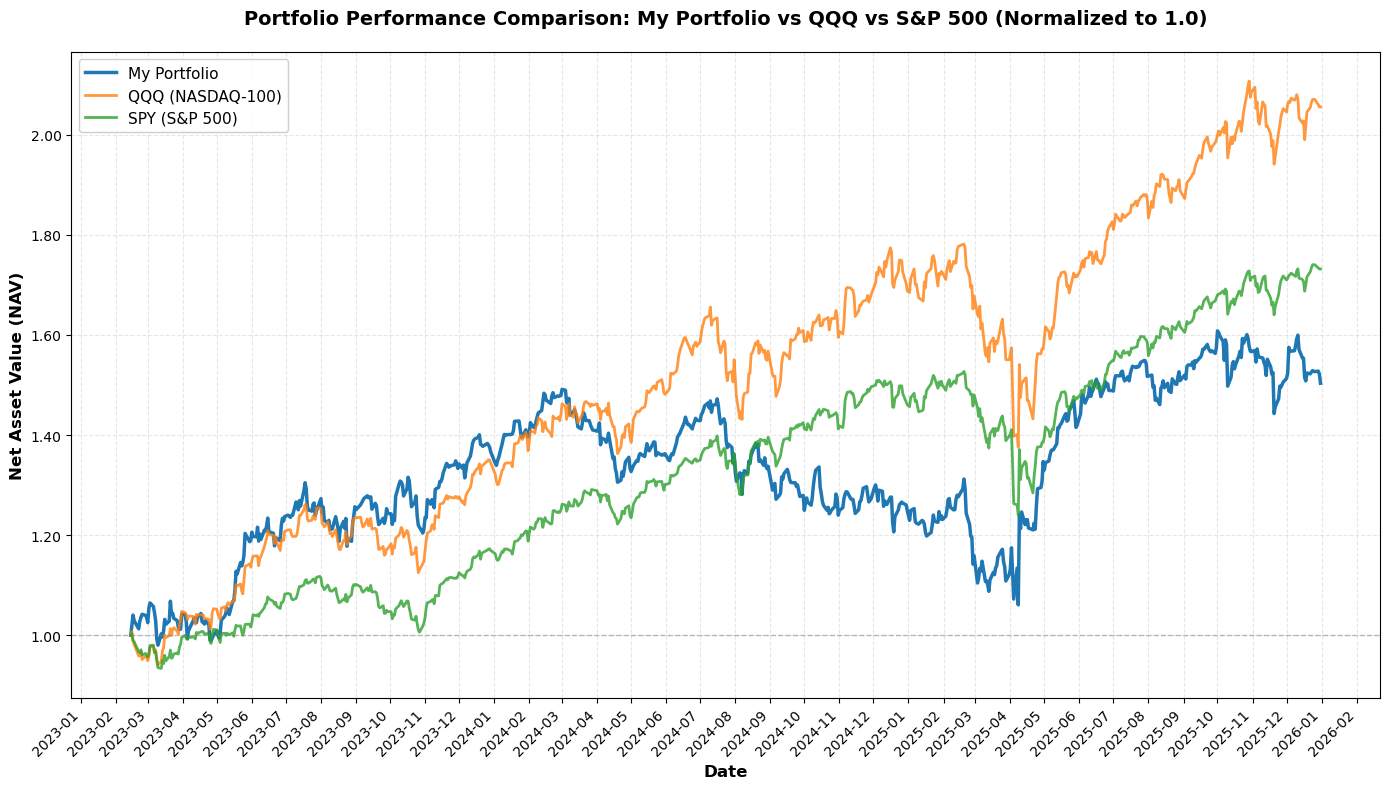

In [40]:
QQQ = yf.download("QQQ", start=result.index.min(), end=result.index.max(), progress=False, multi_level_index=False)
spy = yf.download("SPY", start=result.index.min(), end=result.index.max(), progress=False, multi_level_index=False)

qqq_nav = QQQ['Close'] / QQQ['Close'].iloc[0]
spy_nav = spy['Close'] / spy['Close'].iloc[0]

# Create a dataframe with all NAVs
comparison_df = pd.DataFrame({
    'Portfolio': result['nav'],
    'QQQ': qqq_nav,
    'SPY': spy_nav
})

# Forward fill to handle missing dates
comparison_df = comparison_df.fillna(method='ffill')

# Remove rows with NaN
comparison_df = comparison_df.dropna()

# Normalize all NAV curves to start from 1.0
print("Normalizing NAV curves to start from 1.0...")
comparison_df = comparison_df / comparison_df.iloc[0]

print(f"Aligned data shape: {comparison_df.shape}")
print(f"Date range: {comparison_df.index.min()} to {comparison_df.index.max()}")

fig, ax = plt.subplots(figsize=(14, 8))

# Plot NAV curves
ax.plot(comparison_df.index, comparison_df['Portfolio'], label='My Portfolio', linewidth=2.5, color='#1f77b4')
ax.plot(comparison_df.index, comparison_df['QQQ'], label='QQQ (NASDAQ-100)', linewidth=2, color='#ff7f0e', alpha=0.8)
ax.plot(comparison_df.index, comparison_df['SPY'], label='SPY (S&P 500)', linewidth=2, color='#2ca02c', alpha=0.8)

# Add horizontal line at 1.0
ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Formatting
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Net Asset Value (NAV)', fontsize=12, fontweight='bold')
ax.set_title('Portfolio Performance Comparison: My Portfolio vs QQQ vs S&P 500 (Normalized to 1.0)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

# Format x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')

# Format y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))

plt.tight_layout()

# Save figure
output_file = 'portfolio_comparison_chart.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Chart saved to: {output_file}")

plt.show()

In [41]:
import numpy as np

daily_ret = result["net_ret"]

cum_return = result["nav"].iloc[-1] - 1
annual_ret = (result["nav"].iloc[-1])**(252/len(daily_ret)) - 1
annual_vol = daily_ret.std() * np.sqrt(252)
sharpe = annual_ret / annual_vol

rolling_max = result["nav"].cummax()
drawdown = result["nav"] / rolling_max - 1
mdd = drawdown.min()

print("Cumulative Return:", round(cum_return,4))
print("Annualized Return:", round(annual_ret,4))
print("Annualized Volatility:", round(annual_vol,4))
print("Sharpe Ratio:", round(sharpe,4))
print("Max Drawdown:", round(mdd,4))

Cumulative Return: 0.5036
Annualized Return: 0.1527
Annualized Volatility: 0.2342
Sharpe Ratio: 0.6522
Max Drawdown: -0.2887


Simple Momentum Strategy (2018-01-01 to 2025-12-31)


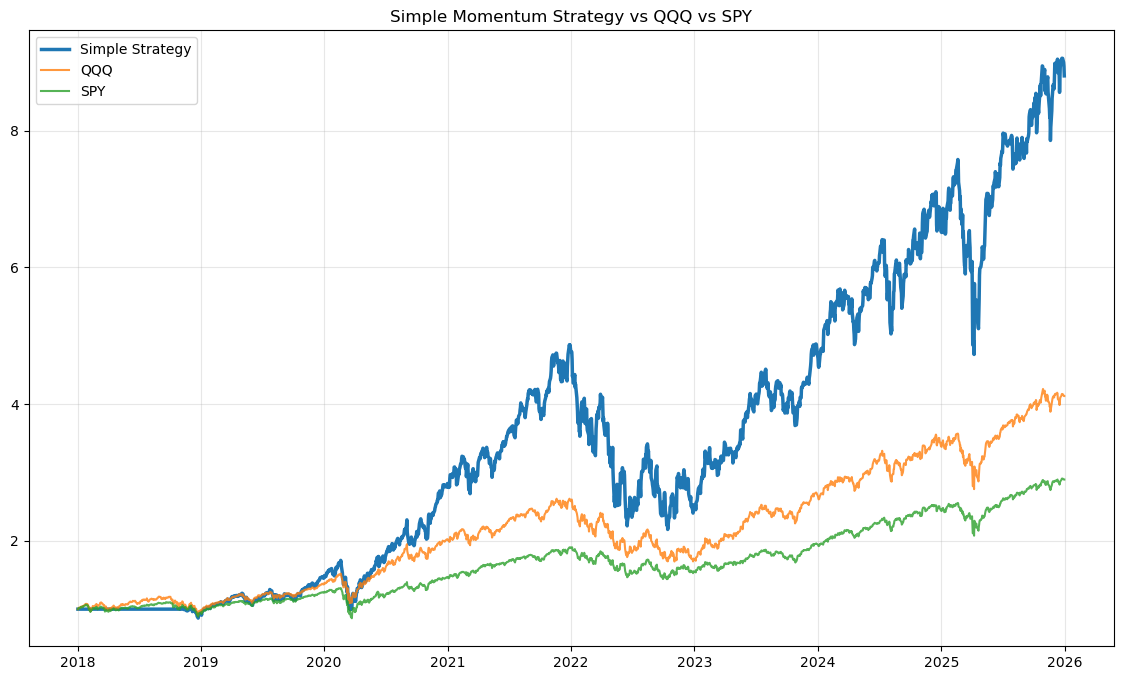

In [46]:
#Simple Cross-Sectional Momentum Strategy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

print("=" * 80)
print("Simple Momentum Strategy (2018-01-01 to 2025-12-31)")
print("=" * 80)

START_DATE = "2018-01-01"
END_DATE = "2025-12-31"

LOOKBACK_MOM = 126
LOOKBACK_VOL = 20
LOOKBACK_TREND = 200

TOP_N = 30
FEE_RATE = 0.001
BEAR_EXPOSURE = 0.5

# Load data
raw = pd.read_csv("nasdaq_stocks.csv", parse_dates=["datadate"])
raw = raw.rename(columns={"datadate": "date", "prccd": "close"})
raw["close_adj"] = raw["close"] / raw["ajexdi"]

price = raw.pivot(index="date", columns="tic", values="close_adj")
price = price.loc[(price.index >= START_DATE) & (price.index <= END_DATE)]
ret = price.pct_change().fillna(0)

# Benchmarks
spy = yf.download("SPY", start=START_DATE, end=END_DATE,
                  auto_adjust=True, progress=False)["Close"]
qqq = yf.download("QQQ", start=START_DATE, end=END_DATE,
                  auto_adjust=True, progress=False)["Close"]

spy = spy.reindex(price.index).ffill()
qqq = qqq.reindex(price.index).ffill()

spy_ma200 = spy.rolling(LOOKBACK_TREND).mean()

# Signals
mom = price / price.shift(LOOKBACK_MOM) - 1
vol = ret.rolling(LOOKBACK_VOL).std() * np.sqrt(252)
ma200 = price.rolling(LOOKBACK_TREND).mean()

rebalance_dates = price.groupby(price.index.to_period("M")).tail(1).index
weights = pd.DataFrame(0, index=price.index, columns=price.columns)

for d in rebalance_dates:

    trend = price.loc[d] > ma200.loc[d]
    score = (mom.loc[d] / vol.loc[d]).where(trend)

    selected = score.dropna().nlargest(TOP_N)

    if selected.empty:
        continue

    w = pd.Series(1/len(selected), index=selected.index)

    # Bear regime
    if float(spy.loc[d]) < float(spy_ma200.loc[d]):
        w *= BEAR_EXPOSURE

    weights.loc[d, w.index] = w.values

weights = weights.replace(0, np.nan).ffill().fillna(0)
weights = weights.shift(1).fillna(0)

turnover = weights.diff().abs().sum(axis=1)
gross_ret = (weights * ret).sum(axis=1)
cost = FEE_RATE * turnover
net_ret = gross_ret - cost

nav = (1 + net_ret).cumprod()

# Plot
plt.figure(figsize=(14,8))
plt.plot(nav, label="Simple Strategy", linewidth=2.5)
plt.plot(qqq/qqq.iloc[0], label="QQQ", alpha=0.8)
plt.plot(spy/spy.iloc[0], label="SPY", alpha=0.8)
plt.legend()
plt.title("Simple Momentum Strategy vs QQQ vs SPY")
plt.grid(alpha=0.3)
plt.show()

In [52]:
# ==============================
# Performance Metrics (2018-01-01 to 2025-12-31)
# ==============================

nav_bt = nav.loc["2018-01-01":"2025-12-31"].dropna()

daily_r = nav_bt.pct_change().fillna(0)
years = (nav_bt.index[-1] - nav_bt.index[0]).days / 365.25

cumulative_return = nav_bt.iloc[-1] - 1
annual_return = nav_bt.iloc[-1]**(1/years) - 1
annual_volatility = daily_r.std() * np.sqrt(252)
sharpe = (daily_r.mean()*252) / annual_volatility
max_drawdown = (nav_bt / nav_bt.cummax() - 1).min()

print("="*60)
print("Backtest Period: 2018-01-01 to 2025-12-31")
print("="*60)
print(f"Cumulative Return: {cumulative_return*100:.2f}%")
print(f"Annual Return: {annual_return*100:.2f}%")
print(f"Annual Volatility: {annual_volatility*100:.2f}%")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_drawdown*100:.2f}%")

Backtest Period: 2018-01-01 to 2025-12-31
Cumulative Return: 780.33%
Annual Return: 31.27%
Annual Volatility: 40.02%
Sharpe Ratio: 0.88
Max Drawdown: -55.52%


In [ ]:
###########################################################################
# Your own strategy and visulization can be built based on the above code #
###########################################################################